In [79]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
train_data = pd.read_table(r'C:\Users\dn\PycharmProjects\TianChi\Input\zhengqi_train.txt')
test_data = pd.read_table(r'C:\Users\dn\PycharmProjects\TianChi\Input\zhengqi_test.txt')

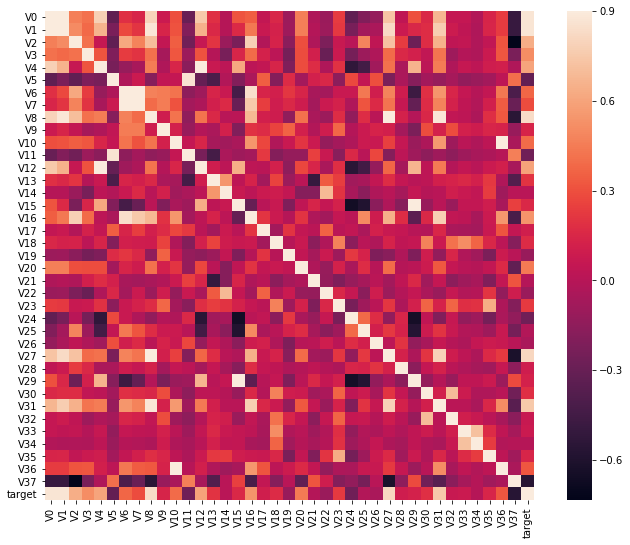

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
corrmat = train_data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

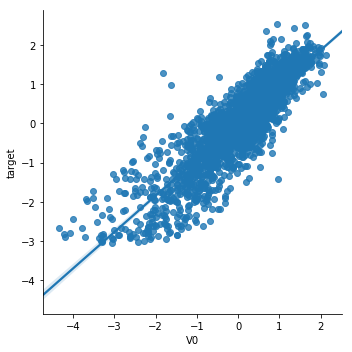

In [81]:
sns.lmplot(x='V0', y='target', data=train_data)

In [82]:
train_data = train_data.drop(train_data[(train_data['V0']<-1.5) & (train_data['target']>-0.5)].index)

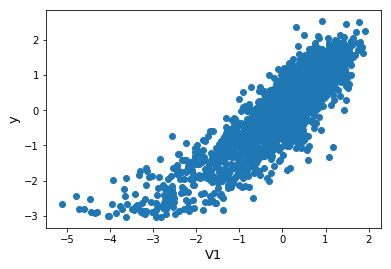

In [83]:
fig, ax = plt.subplots()
ax.scatter(x = train_data['V1'], y = train_data['target'])
plt.ylabel('y', fontsize=13)
plt.xlabel('V1', fontsize=13)
plt.show()

In [84]:
train_data = train_data.drop(train_data[(train_data['V1']<-4.5)].index)

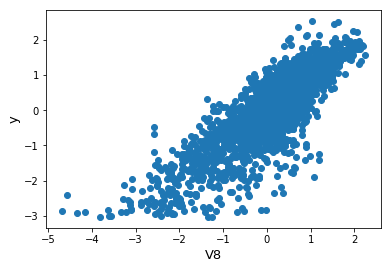

In [85]:
fig, ax = plt.subplots()
ax.scatter(x = train_data['V8'], y = train_data['target'])
plt.ylabel('y', fontsize=13)
plt.xlabel('V8', fontsize=13)
plt.show()


 mu = 0.13 and sigma = 0.98



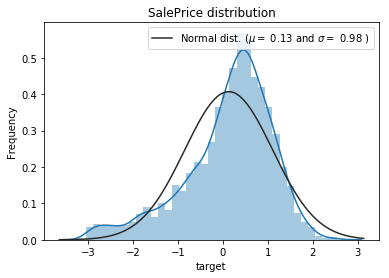

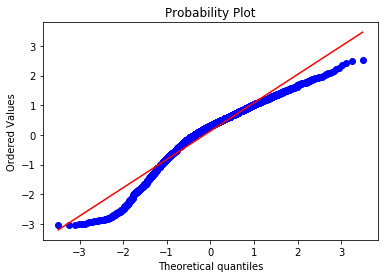

In [86]:
from scipy import stats
from scipy.stats import norm, skew
sns.distplot(train_data['target'] , fit=norm)
# 正态分布拟合
(mu, sigma) = norm.fit(train_data['target'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# 绘图
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# 原始数据分布绘图
fig = plt.figure()
res = stats.probplot(train_data['target'], plot=plt)
plt.show()

In [87]:

train.shape

(2875, 38)

In [88]:
test.shape

(1925, 38)

In [89]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold,train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression,Ridge,SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import numpy as np
n_folds = 5
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
y_train = train_data.target.values
all_data = pd.concat((train_data, test_data)).reset_index(drop=True)
all_data.drop(['target'], axis=1, inplace=True)
scaler=StandardScaler()
train = scaler.fit_transform(all_data[:ntrain])
test = scaler.transform(all_data[ntrain:])
def rmsle_cv(model,X,Y):
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse= np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


In [90]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),xgb.XGBRegressor(),lgb.LGBMRegressor()]

In [91]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb","Lgb"]
for name, model in zip(names, models):
    score = rmsle_cv(model, train, y_train)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 0.325242, 0.0158
Ridge: 0.325212, 0.0158
Lasso: 0.339250, 0.0167
RF: 0.357404, 0.0154
GBR: 0.328254, 0.0157
SVR: 0.361388, 0.0146
LinSVR: 0.327599, 0.0161
Ela: 0.325170, 0.0160
SGD: 0.334812, 0.0160
Bay: 0.325191, 0.0159
Ker: 0.320702, 0.0156
Extra: 0.356245, 0.0181
Xgb: 0.330603, 0.0152
Lgb: 0.324687, 0.0153


In [92]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [93]:
grid(Lasso()).grid_get(train,y_train,{'alpha': [0.0004,0.0005,0.0007,0.0009],'max_iter':[10000]})

{'alpha': 0.0009, 'max_iter': 10000} 0.33507032439599804
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.335409        0.018724
1  {'alpha': 0.0005, 'max_iter': 10000}         0.335336        0.018780
2  {'alpha': 0.0007, 'max_iter': 10000}         0.335208        0.018904
3  {'alpha': 0.0009, 'max_iter': 10000}         0.335070        0.019077


In [94]:
grid(Ridge()).grid_get(train,y_train,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 35} 0.335850262784703
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.335850        0.019771
1  {'alpha': 40}         0.336132        0.019793
2  {'alpha': 45}         0.336431        0.019801
3  {'alpha': 50}         0.336740        0.019797
4  {'alpha': 55}         0.337057        0.019784
5  {'alpha': 60}         0.337376        0.019765
6  {'alpha': 65}         0.337696        0.019741
7  {'alpha': 70}         0.338016        0.019713
8  {'alpha': 80}         0.338646        0.019648
9  {'alpha': 90}         0.339261        0.019577


In [95]:
grid(SVR()).grid_get(train,y_train,{'C':[11,13,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, 'kernel': 'rbf'} 0.33311114456677127
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.335756   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.333623   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.335834   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.333572   
4   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.334913   
5   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.333516   
6   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.334923   
7   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.333435   
8   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.334331   
9   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.333111   
10  {'C': 15, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.334190   
11  {'C': 15, 'epsilon': 0.009

In [96]:
param_grid={'alpha':[0.2,0.3,0.4], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1]}
grid(KernelRidge()).grid_get(train,y_train,param_grid)

{'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'kernel': 'polynomial'} 0.45968356207984895
                                              params  mean_test_score  \
0  {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.521082   
1  {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.533167   
2  {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.483440   
3  {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.494436   
4  {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.459684   
5  {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.469711   

   std_test_score  
0        0.046204  
1        0.051526  
2        0.040476  
3        0.045418  
4        0.035889  
5        0.040474  


In [97]:
grid(ElasticNet()).grid_get(train,y_train,{'alpha':[0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3],'max_iter':[10000]})

{'alpha': 0.004, 'l1_ratio': 0.1, 'max_iter': 10000} 0.33512109776553806
                                              params  mean_test_score  \
0  {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.335586   
1  {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.335571   
2  {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.335440   
3  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.335123   
4  {'alpha': 0.004, 'l1_ratio': 0.1, 'max_iter': ...         0.335121   
5  {'alpha': 0.004, 'l1_ratio': 0.3, 'max_iter': ...         0.335147   
6  {'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter':...         0.335137   
7  {'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': ...         0.335156   
8  {'alpha': 0.005, 'l1_ratio': 0.3, 'max_iter': ...         0.335307   

   std_test_score  
0        0.018680  
1        0.018687  
2        0.018745  
3        0.019209  
4        0.019214  
5        0.019455  
6        0.019299  
7        0.019299  
8        0.01963

In [98]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # 遍历拟合原始模型
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # 得到基模型，并用基模型对out_of_fold做预估，为学习stacking的第2层做数据准备
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # 学习stacking模型
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # 做stacking预估
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [107]:
stacked_averaged_models = StackingAveragedModels(base_models = (LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),xgb.XGBRegressor(),lgb.LGBMRegressor()),
                                                 meta_model = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5))

score = rmsle_cv(stacked_averaged_models,train,y_train)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.3085 (0.0158)


In [108]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


In [109]:
model_xgb=xgb.XGBRegressor()
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred =model_xgb.predict(test)
print(rmsle(y_train, xgb_train_pred))

0.26569469257426087


In [110]:
model_lgb=lgb.LGBMRegressor()
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred=model_lgb.predict(test)
print(rmsle(y_train, lgb_train_pred))

0.13741828607753798


In [112]:
stacked_averaged_models.fit(train, y_train)
stacked_train_pred = stacked_averaged_models.predict(train)
stacked_pred=stacked_averaged_models.predict(test)
print(rmsle(y_train, stacked_train_pred))

0.21923522502133586


In [117]:
print('训练集上的RMSLE得分:')
print(rmsle(y_train,xgb_train_pred*0.05  + lgb_train_pred*0.15+ stacked_train_pred*0.8))

训练集上的RMSLE得分:
0.20550191571833581


In [119]:
ensemble =lgb_pred*0.15 + xgb_pred*0.05+stacked_pred*0.8

In [120]:
len(ensemble)

1925

In [121]:
sub = pd.DataFrame()
sub['SalePrice'] = ensemble
sub.to_csv('.\predict.txt',header=False,index=False)